In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In this notebook I develop a program to play Tic Tac Toe. First I create a dictionary which contains the Markov Chain. The game state is the dictionaries key, the value contains a list of probabilities for the players next move. The chain is initiated with even probabilities for all moves.

I then define a smart player ('Player'), a dumb player ('RandomPlayer') and a game ('TTT').

In order to populate the chain I initiate two smart players. Player 1 then plays against player 2. The players first pick moves randomly, after the game finishes the probabilities in the chain are updated. The winning path probabilities are increased, the losing path probabilities are decreased.

The chain is generated by playing 25000 games. 

After the chain was developed I test the chain against a player which plays randomly. 

In [19]:
def initiate_chain():
    '''
    returns a dictionary. key is blank board. 
    values are list :
    item one is future states which has been visited - this section currently isnt used. 
    item two is move weights
    '''
    k = '0'*9
    chain = {}
    chain[k] = [[0]*9, [1]*9]
    return chain
    

In [20]:
class Player(object):
    '''
    Player Class. This player plays a 'smart' strategy.
    '''
    def __init__(self, player_number):
        self.player_number = player_number
        self.state = '0'*9
        self.path = []
        
    def reinitialize(self):
        self.path = []
        self.state = '0'*9
    
    def next_move(self):
        # find the next pick
        try:
            vist_weight = chain[self.state]
            weights = vist_weight[1]
        except:
            chain[self.state] = [[0]*9, [1]*9]
            weights = [1]*9
        choices = [0,1,2,3,4,5,6,7,8]
 
        # I have create a list of probabilities based on a combination of board state and weights
        
        list_state = list(self.state)
        percentages = []
        for i, x in enumerate(list_state):
            if x == '1' or x == '2':
                percentages.append(0)
            else:
                percentages.append(weights[i])
                
        percentages = np.array(percentages)
        tot = percentages.sum()
        percentages = percentages/tot
        
        # Pick next move
        pick = np.random.choice(choices, p=percentages)
        
        # update player state
        list_state = list(self.state)
        list_state[pick] = self.player_number
        self.state = "".join(list_state)
        
        # update path
        self.path.append(pick)

In [21]:
class RandomPlayer(object):
    '''
    this is a dumb player which makes random moves
    '''
    def __init__(self, player_number):
        self.player_number = player_number
        self.state = '0'*9
        self.path = []
    
    def next_move(self):
        # find the next pick randomly
        list_state = list(self.state)
        percentages = []
        choices = [0,1,2,3,4,5,6,7,8]
        for x in list_state:
            if x == '1' or x == '2':
                percentages.append(0)
            else:
                percentages.append(1)
        percentages = np.array(percentages)
        percentages = percentages/(np.sum(percentages))
                
        pick = np.random.choice(choices, p=percentages)
        
        # update player state
        list_state = list(self.state)
        list_state[pick] = self.player_number
        self.state = "".join(list_state)
        
        #update path
        self.path.append(pick)
        
    def reinitialize(self):
        self.path = []
        self.state = '0'*9

In [22]:
class TTT(object):
    '''
    Game Class, initiates players and modifys the chain.
    '''
    def __init__(self, games = 1):
        self.player_1 = Player('1')
        self.player_2 = Player('2')
        self.randomplayer_2 = RandomPlayer('2')
        self.games = games
        self.results = []
        self.gameresults = []
    
    def play_game(self):
        game = 0
        while game < self.games:
            game_result = self.game_over()
            if game_result == 'unfinished':
                self.player_1.next_move()
                self.randomplayer_2.state = self.player_1.state
                self.randomplayer_2.next_move()
                self.player_1.state = self.randomplayer_2.state
                #print('unfinished')
            else:
                self.player_1.reinitialize()
                self.randomplayer_2.reinitialize()
                game += 1
                self.gameresults.append(game_result)
                #print(f'game number {game}')
             
    def solve(self):
        game = 0
        while game < self.games:
            #print(game)
            game_result = self.game_over()
            #print(game_result)
            #print(''.join(self.player_1.state))
            if game_result == 'unfinished':
                self.player_1.next_move()
                self.player_2.state = self.player_1.state
                self.player_2.next_move()
                self.player_1.state = self.player_2.state
                #print('unfinished')
            else:
                self.update_chain(game_result)
                self.player_1.reinitialize()
                self.player_2.reinitialize()
                #print('next game')
                game += 1
                self.results.append(game_result)
                #print(f'game number {game}')
        
    def update_chain(self, game_result):
        tracking_state = [0]*9
        tracking_state_str = "".join(str(e) for e in tracking_state)
        for i, p in enumerate(self.player_1.path):  
            if game_result == 'one':
                chain[tracking_state_str][1][p] *= 2.0
            elif game_result == 'two':
                chain[tracking_state_str][1][p] *= .95
                
            tracking_state[p] = self.player_1.player_number
            tracking_state_str = "".join(str(e) for e in tracking_state)
            
            p2p = self.player_2.path[i]
            
            if game_result == 'one':
                chain[tracking_state_str][1][p2p] *= .95
            elif game_result == 'two':
                chain[tracking_state_str][1][p2p] *= 2.0
            
            tracking_state[p2p] = self.player_2.player_number
            tracking_state_str = "".join(str(e) for e in tracking_state)

    def game_over(self):
        gs = ''.join(self.player_1.state)
        numbers = [[0,1,2], [3,4,5], [6,7,8], [0,3,6], [1,4,7], [2,5,8], [0,4,8], [2,4,6]]
        for num in numbers:
            result = self.check(num,gs,'1')
            if result == True:
                return 'one'
            result2 = self.check(num,gs,'2')
            if result2 == True:
                return 'two'
            if '0' not in gs:
                return 'draw'
            else:
                return 'unfinished'
    
    def check(self, nums, gs, s):
        one, two, three = nums
        if gs[one] == s and gs[two] == s and gs[three] == s:
            return True
        else:
            return False

Initiating the chain and the game.

In [23]:
chain = initiate_chain()

game = TTT(games=25000)

Updating the chain with 25000 instances of the game. 

In [24]:
game.solve()

Graphing the results.

In [62]:
numbers = []
draws = []
ones = []
twos = []
for x in game.results:
    if x == 'draw':
        draws.append(1)
        ones.append(0)
        twos.append(0)
    if x == 'one':
        draws.append(0)
        ones.append(1)
        twos.append(0)
    if x == 'two':
        draws.append(0)
        ones.append(0)
        twos.append(1)
draw_100 = [np.sum(draws[x:x+100:]) for x in range(len(draws))]
one_100 = [np.sum(ones[x:x+100:]) for x in range(len(ones))]
two_100 = [np.sum(twos[x:x+100:]) for x in range(len(twos))]
draw_100 = np.array(draw_100)
one_100 = np.array(one_100)
two_100 = np.array(two_100)

draws = np.cumsum(np.array(draws))
ones = np.cumsum(np.array(ones))
twos = np.cumsum(np.array(twos))


In [26]:
totals = draws+ ones+twos 
draw_ratio = draws/totals 
one_ratio = ones/totals
two_ratio = twos/totals

In [27]:
ys = list(range(len(draws)))

Graphing the total number of each final game state. 

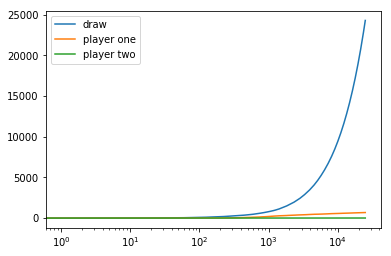

In [28]:
plt.plot(ys,draws, label='Draw')
plt.plot(ys,ones, label='Player One Wins')
plt.plot(ys,twos, label='Player Two Wins')
plt.xscale('log')
plt.title('Cumulative Game Results')
plt.ylabel('Number of Results')
plt.xlabel('Game Number (log)')
plt.legend(title='Final State')
plt.plot()

Ploting the changing ratios of ending states.

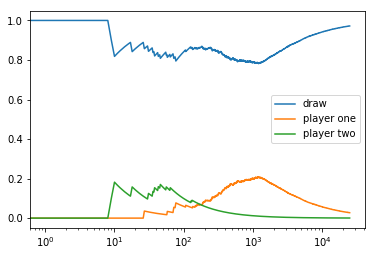

In [29]:
plt.plot(ys,draw_ratio, label='Draw')
plt.plot(ys,one_ratio, label='Player One')
plt.plot(ys,two_ratio, label='Player Two')
plt.title('% of Total Games Finishing in Given State')
plt.xlabel('Game Number (log)')
plt.ylabel('Percentage of States')
plt.xscale('log')
plt.legend(title='Final State')
plt.plot()

Two players playing perfectly should always draw. The above graph shows a convergence towards all games resulting in draws. The below cell shows a draw ratio in the later game states very close to 100%. 

In [30]:
draw_ratio[24999]

0.97208

This ratio considers all past games too though - so does not properly represent how good the model is once fully trained. The below graphs the number of games finishing in a given state for every 100 games. A rolling win/loss/draw ratio.

In [ ]:
total_100 = draw_100 + one_100 + two_100 
draw_100_ratio = draw_100/total_100 
one_100_ratio = one_100/total_100
two_100_ratio = two_100/total_100

Ploting the changing ratios of ending states using a 100 game rolling window.

[]

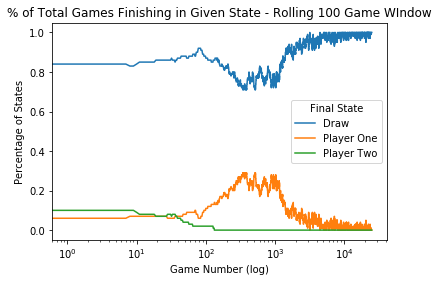

In [69]:
plt.plot(ys,draw_100_ratio, label='Draw')
plt.plot(ys,one_100_ratio, label='Player One')
plt.plot(ys,two_100_ratio, label='Player Two')
plt.title('% of Total Games Finishing in Given State - Rolling 100 Game Window')
plt.xlabel('Game Number (log)')
plt.ylabel('Percentage of Final States')
plt.xscale('log')
plt.legend(title='Final State')
plt.plot()

In [67]:
draw_100_ratio[24999]

1.0

Did I just brute force the game then? Not quite - the chain developed by the model has 1000's of fewer states than possible(5,478). 

In [31]:
len(chain)

2134

# Playing a Dumb Opponent

Below I play a game between a smart player and a player who plays randomly. The smart player is player 1, player 2 is the random player. 

The reason that player 1 does not win more games is because player 1 still plays with a weighted random pick - instead of using the absolute best move given a situation. Notice that player 2 never wins.  

In [32]:
game.play_game()

Graphing the total number of each final game state. 

In [33]:
numbers = []
draws = []
ones = []
twos = []
for x in game.gameresults:
    if x == 'draw':
        draws.append(1)
        ones.append(0)
        twos.append(0)
    if x == 'one':
        draws.append(0)
        ones.append(1)
        twos.append(0)
    if x == 'two':
        draws.append(0)
        ones.append(0)
        twos.append(1)
draws = np.cumsum(np.array(draws))
ones = np.cumsum(np.array(ones))
twos = np.cumsum(np.array(twos))
totals = draws+ ones+twos 
draw_ratio = draws/totals 
one_ratio = ones/totals
two_ratio = twos/totals
ys = list(range(len(draws)))

[]

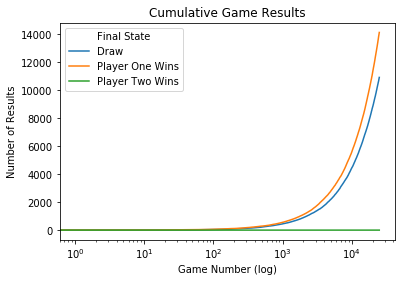

In [40]:
plt.plot(ys,draws, label='Draw')
plt.plot(ys,ones, label='Player One Wins')
plt.plot(ys,twos, label='Player Two Wins')
plt.xscale('log')
plt.title('Cumulative Game Results')
plt.ylabel('Number of Results')
plt.xlabel('Game Number (log)')
plt.legend(title='Final State')
plt.plot()

Ploting the changing ratios of ending states.

[]

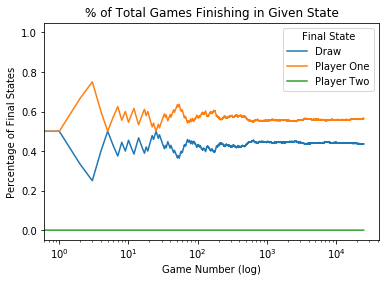

In [70]:
plt.plot(ys,draw_ratio, label='Draw')
plt.plot(ys,one_ratio, label='Player One')
plt.plot(ys,two_ratio, label='Player Two')
plt.title('% of Total Games Finishing in Given State')
plt.xlabel('Game Number (log)')
plt.ylabel('Percentage of Final States')
plt.xscale('log')
plt.legend(title='Final State')
plt.plot()